# 0 TCLab Overview

The following cells in this notebook demonstrate the use of the Temperature Control Lab.

## TCLab Architecture
<img src='images/TCLabOverview.png' style="float: left;padding-right:30px;"></img>
**_Jupyter notebooks:_**
Examples, lessons, and student projects.

**_tclab:_**
A package to provide high-level access to sensors, heaters, a pseudo-realtime clock. The package includes `TCLab()` providing access to the device, `clock` for synchronizing with a real time clock, `Historian` for data logging and `Plotter` for realtime plotting.

**_sketch.ino:_**
Firmware for the intrisically safe operation of the Arduino board and shield.

**_Arduino:_**
Hardware platform for the Temperature Control Laboratory. Compatiable with Arduino Uno and Arduino Leonardo.

## Connecting to the Temperature Control Laboratory

### Importing

When used for the first time, the `tclab` package is installed with the command line

    pip install tclab
    
Once it has been installed, the package can be imported into Python and an instance created with the Python statements

    from tclab import TCLab
    a = TCLab()

TCLab() attempts to find a device connected to a serial port and returns a connection. An error is generated if no device is found.  The connection should be closed when no longer in use.

The following cell demonstrates this process, and uses the tclab `LED()` function to flash the LED on the Temperature Control Lab for a period of 10 seconds at a 100% brightness level. 

In [1]:
from tclab import TCLab, clock

a = TCLab()
a.LED(100)
a.close()

Connecting to TCLab
TCLab Firmware Version 1.2.1 on NHduino connected to port /dev/cu.wchusbserial1410
TCLab disconnected successfully.


### Using TCLab with Python's `with` statement

The Python `with` statement provides a convenient means of setting up and closing a connection to the Temperature Control Laboratory. In particular, the with statement establishes a context where a tclab instance is created, assigned to a variable, and automatically closed upon completion.

In [2]:
from tclab import TCLab

with TCLab() as a:
    a.LED(100)

Connecting to TCLab
TCLab Firmware Version 1.2.1 on NHduino connected to port /dev/cu.wchusbserial1410
TCLab disconnected successfully.


The `with` statement is likely to be the most common way to connect the Temperature Control Laboratory for most uses.

## Reading Temperatures

Once a tclab instance is created and connected to a device, the temperature sensors on the temperature control lab can be acccessed with the attributes `.T1` and `.T2`.  For example, given an instance `a`, the temperatures are accessed as

    T1 = a.T1
    T2 = a.T2

Note that `a.T1` and `a.T2` are read-only properties. Any attempt to set them to a value will return a Python error.

In [3]:
from tclab import TCLab

with TCLab() as a:
    print("Temperature 1: {0:0.2f} °C".format(a.T1))
    print("Temperature 2: {0:0.2f} °C".format(a.T2))

Connecting to TCLab
TCLab Firmware Version 1.2.1 on NHduino connected to port /dev/cu.wchusbserial1410
Temperature 1: 19.93 °C
Temperature 2: 20.25 °C
TCLab disconnected successfully.


## Setting Heaters

The heaters are controlled by functions`.Q1()` and `.Q2()` of a tclab instance. For example, both heaters can be set to 100% power with the functions

    a.Q1(100)
    a.Q2(100)

The device firmware limits the heaters to a range of 0 to 100%. The current value of attributes may be accessed via

    Q1 = a.Q1()
    Q2 = a.Q2()
    
Note that the retrieved values may be different due to the range-limiting enforced by the device firmware.

In [4]:
from tclab import TCLab
import time

with TCLab() as a:
    print("\nStarting Temperature 1: {0:0.2f} °C".format(a.T1),flush=True)
    print("Starting Temperature 2: {0:0.2f} °C".format(a.T2),flush=True)

    a.Q1(100)
    a.Q2(100)
    print("\nSet Heater 1:", a.Q1(), "%",flush=True)
    print("Set Heater 2:", a.Q2(), "%",flush=True)
    
    t_heat = 30
    print("\nHeat for", t_heat, "seconds")
    time.sleep(t_heat)

    print("\nTurn Heaters Off")
    a.Q1(0)
    a.Q2(0)
    print("\nSet Heater 1:", a.Q1(), "%",flush=True)
    print("Set Heater 2:", a.Q2(), "%",flush=True)
    
    print("\nFinal Temperature 1: {0:0.2f} °C".format(a.T1))
    print("Final Temperature 2: {0:0.2f} °C".format(a.T2))

Connecting to TCLab
TCLab Firmware Version 1.2.1 on NHduino connected to port /dev/cu.wchusbserial1410

Starting Temperature 1: 19.61 °C
Starting Temperature 2: 20.25 °C

Set Heater 1: 100.0 %
Set Heater 2: 100.0 %

Heat for 30 seconds

Turn Heaters Off

Set Heater 1: 0.0 %
Set Heater 2: 0.0 %

Final Temperature 1: 23.48 °C
Final Temperature 2: 21.87 °C
TCLab disconnected successfully.


## Synchronizing with Real Time using `clock`

The tclab module includes a function `clock` for synchronizing calculations with real time.  `clock(tperiod)` is an iterator that generates a sequence of equally spaced time steps from zero to `tperiod`  separated by one second intervals. For each step `clock` returns time since start rounded to the nearest 10th of a second.

In [5]:
from tclab import clock

tperiod = 5
for t in clock(tperiod):
    print(t, "sec.")

0 sec.
1.0 sec.
2.0 sec.
3.0 sec.
4.0 sec.
5.0 sec.


An optional parameter `tstep` specifies a time step different from one second.

In [6]:
from tclab import clock

tperiod = 5
tstep = 2.5
for t in clock(tperiod,tstep):
    print(t, "sec.")

0 sec.
2.5 sec.
5.0 sec.


There are some considerations when using `clock`. First, by its nature Python is not a real-time environment. `clock` makes a best effort to stay in sync with the wall clock, but there can be no guarantees.

The default behavior of `clock` is to maintain long-term synchronization with the real time clock. A `RuntimeError` exception is raised if the difference between clock and a grid of equally spaced intervals is greater than optional parameter `tol` (default value of 0.1 seconds).

In [7]:
from tclab import clock

import time

tfinal = 5
tstep = 1
for t in clock(tfinal, tstep, tol=0.25):
    print(t, "sec.")
    if 0.5 < t < 2.5:
        time.sleep(1.1)

0 sec.
1.0 sec.
2.1 sec.
3.2 sec.
4.0 sec.
5.0 sec.


When the optional flag `strict` is set to False, `clock` attempts to maintain equal time intervals even at the loss of long-term synchronization.

In [8]:
from tclab import TCLab, clock

import time

tfinal = 5
tstep = 1
for t in clock(tfinal, tstep, strict=False, tol=0.2):
    print(t, "sec.")
    if 0.5 < t < 2.5:
        time.sleep(1.1)

0 sec.
1.0 sec.
2.1 sec.
3.2 sec.
4.2 sec.


### Using `clock` with TCLab

In [9]:
from tclab import TCLab, clock

tperiod = 20

# connect to the temperature control lab
with TCLab() as a:
    # turn heaters on
    a.Q1(100)
    a.Q2(100)
    print("\nSet Heater 1 to {0:f} %".format(a.Q1()))
    print("Set Heater 2 to {0:f} %".format(a.Q2()))

    # report temperatures for the next tperiod seconds
    sfmt = "   {0:5.1f} sec:   T1 = {1:0.1f} °C    T2 = {2:0.1f} °C"
    for t in clock(tperiod, 2):
        print(sfmt.format(t, a.T1, a.T2), flush=True)
        

Connecting to TCLab
TCLab Firmware Version 1.2.1 on NHduino connected to port /dev/cu.wchusbserial1410

Set Heater 1 to 100.000000 %
Set Heater 2 to 100.000000 %
     0.0 sec:   T1 = 25.4 °C    T2 = 22.8 °C
     2.0 sec:   T1 = 25.7 °C    T2 = 23.1 °C
     4.0 sec:   T1 = 26.1 °C    T2 = 23.5 °C
     6.0 sec:   T1 = 25.7 °C    T2 = 23.1 °C
     8.0 sec:   T1 = 26.1 °C    T2 = 22.8 °C
    10.0 sec:   T1 = 26.1 °C    T2 = 23.5 °C
    12.0 sec:   T1 = 26.4 °C    T2 = 23.5 °C
    14.0 sec:   T1 = 26.7 °C    T2 = 23.5 °C
    16.0 sec:   T1 = 26.4 °C    T2 = 23.5 °C
    18.0 sec:   T1 = 27.0 °C    T2 = 24.1 °C
    20.0 sec:   T1 = 27.0 °C    T2 = 23.5 °C
TCLab disconnected successfully.


## The TCLab `Historian`

### Basic logging

The `Historian` class provides data logging. Given an instance of a TCLab object, an Historian is created with the command

    h = Historian(a.sources)
    
The historian initializes a data log. The data log is updated by issuing a command

    h.update(t)
    
Where `t` is the current clock time. If `t` is omitted, the historian will calculate its own time.

In [10]:
from tclab import TCLab, clock, Historian

with TCLab() as a:
    h = Historian(a.sources)
    for t in clock(20):
        a.Q1(100 if t <= 10 else 0)
        print("Time:", t, 'seconds')
        h.update(t)        

Connecting to TCLab
TCLab Firmware Version 1.2.1 on NHduino connected to port /dev/cu.wchusbserial1410
Time: 0 seconds
Time: 1.0 seconds
Time: 2.0 seconds
Time: 3.0 seconds
Time: 4.0 seconds
Time: 5.0 seconds
Time: 6.0 seconds
Time: 7.0 seconds
Time: 8.0 seconds
Time: 9.0 seconds
Time: 10.0 seconds
Time: 11.0 seconds
Time: 12.0 seconds
Time: 13.0 seconds
Time: 14.0 seconds
Time: 15.0 seconds
Time: 16.0 seconds
Time: 17.0 seconds
Time: 18.0 seconds
Time: 19.0 seconds
Time: 20.0 seconds
TCLab disconnected successfully.


### Accessing the Data Log from the Historian

`Historian` maintains a data log that is updated on each encounter of the `.update()` function. Individual time series are available as elements of `Historian.fields`:

    t, T1, T2, Q1, Q2 = h.fields 

For example, here's how to plot the history of temperature T1 versus time from the example above.

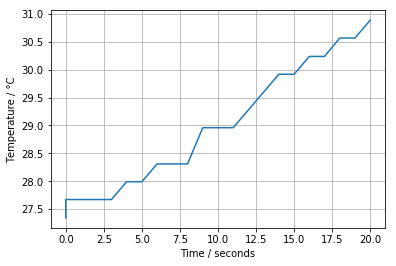

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

t, T1, T2, Q1, Q2 = h.fields 
plt.plot(t, T1)
plt.xlabel('Time / seconds')
plt.ylabel('Temperature / °C')
plt.grid()

The entire data history is available from the historian as the attribute `.log`. Here we show the first three rows from the log:

In [12]:
h.log[:3]

[(0, 27.34, 24.12, 0.0, 0.0),
 (0, 27.67, 24.12, 100.0, 0.0),
 (1.0, 27.67, 24.12, 100.0, 0.0)]

### Accessing log data via Pandas

Here's an example of how the log can be converted to a Pandas dataframe.

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

df = pd.DataFrame.from_records(h.log, columns=h.columns, index='Time')
df.head()

,T1,T2,Q1,Q2
Time,,,,
0.0,27.34,24.12,0.0,0.0
0.0,27.67,24.12,100.0,0.0
1.0,27.67,24.12,100.0,0.0
2.0,27.67,24.44,100.0,0.0
3.0,27.67,24.12,100.0,0.0


The following cells provide examples of plots that can be constructed once the data log has been converted to a pandas dataframe.

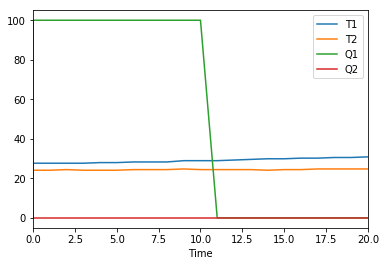

In [14]:
df.plot()

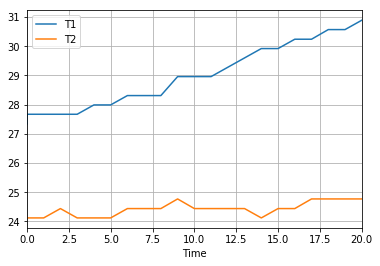

In [15]:
df[['T1','T2']].plot(grid=True)

### Real time plots with Plotter
When operating in a Jupyter Notebook, a `Plotter` can be used together with the `Historian`.  

    h = Historian(a)
    p = Plotter(h, tfinal)
    
where `a` is a `TCLab` instance as before and the optional parameter `tfinal` provides an initial scaling of the time axes. Each call to `p.update()` will automatically update both the historian and the plot.

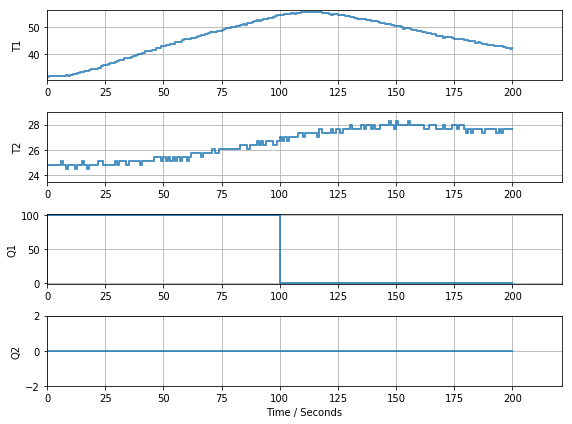

TCLab disconnected successfully.


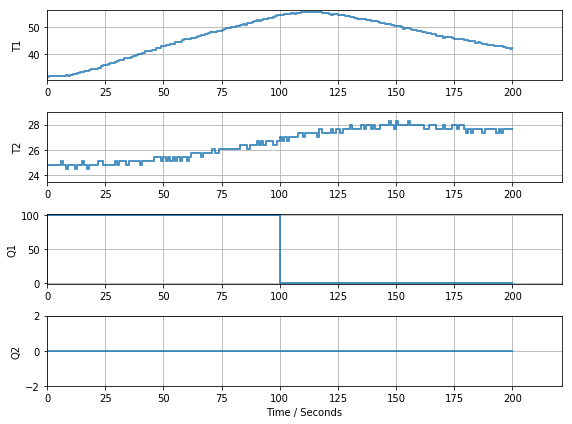

In [16]:
%matplotlib inline
from tclab import TCLab, clock, Historian, Plotter

with TCLab() as a:
    h = Historian(a.sources)
    p = Plotter(h)
    for t in clock(200):
        a.Q1(100 if t < 100 else 0)
        p.update(t)

## TCLab Model

`TCLabModel` replaces `TCLab` for occasions where the TCLab hardware might not be available. To use, include the import

    from tclab import TCLabModel as TCLab 
    
The rest of your code will work without change. Be advised the underlying model used to approximate the behavior of the Temperature Control Laboratory is an approximation to the dynamics of the actual hardware.

In [17]:
from tclab import TCLabModel as TCLab

with TCLab() as a:
    print("Temperature 1: {0:0.2f} °C".format(a.T1))
    print("Temperature 2: {0:0.2f} °C".format(a.T2))

Simulated TCLab
Temperature 1: 20.94 °C
Temperature 2: 21.23 °C
Surrogate TCLab disconnected successfully.


As an additional example.

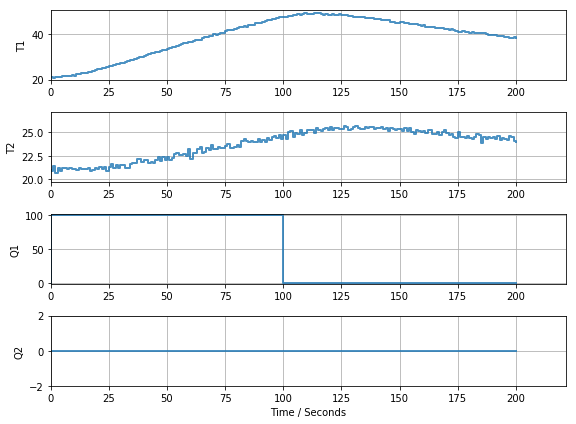

Surrogate TCLab disconnected successfully.


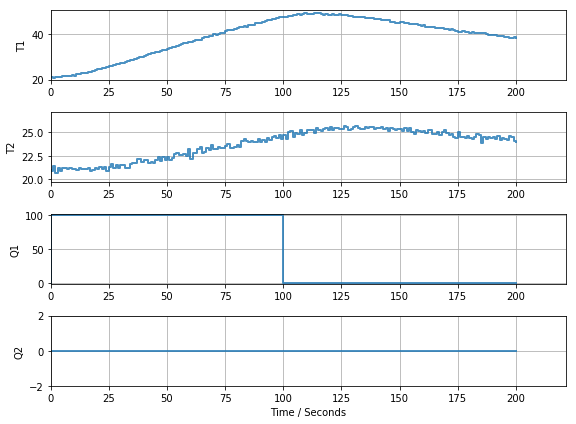

In [18]:
%matplotlib inline
from tclab import TCLabModel as TCLab
from tclab import clock, Historian, Plotter

with TCLab() as a:
    h = Historian(a.sources)
    p = Plotter(h)
    for t in clock(200):
        a.Q1(100 if t < 100 else 0)
        p.update(t)

### Speedup Factor with `setup()`

The setup function provides control over the use of the TCLab hardware or model. If using a model, an option to run at a multiple of real-time.

A speedup of 10 or greater causes the simulation to run as fast as possible.

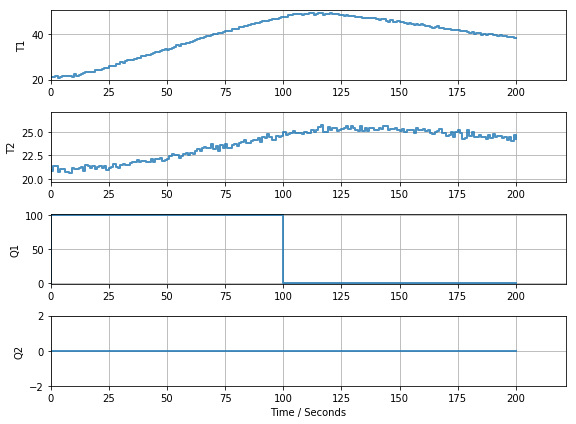

Surrogate TCLab disconnected successfully.


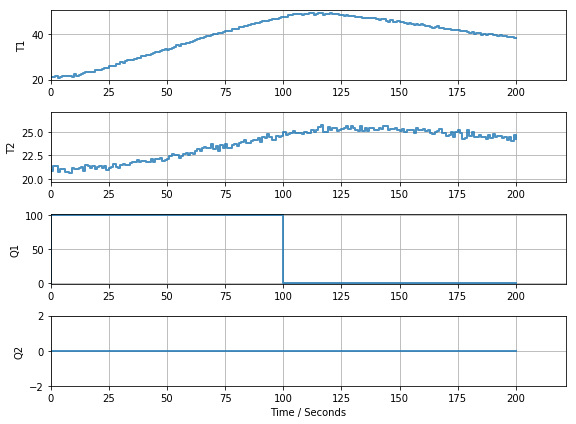

In [19]:
%matplotlib inline
from tclab import clock, Historian, Plotter, setup

TCLab = setup(connected=False, speedup=20)

with TCLab() as a:
    h = Historian(a.sources)
    p = Plotter(h)
    for t in clock(200):
        a.Q1(100 if t < 100 else 0)
        p.update(t)

## Setting Maximum Heater Power

Heater power is normally set with `Q1` and `Q2` by specifying a value in a range from 0 to 100% of maximum heater power.  The values of maximum heater power, in turn, are specified in firmware in units of pulse-width-modulation (pwm) that range from 0 to 255. The default values are 200 for heater 1 and 100 for heater 2. 

The maximum heater power can be retrieved and set by properties `P1` and `P2`. The following code sets both heaters to maximum power of pwm = 100.

In [20]:
from tclab import TCLab

with TCLab() as a:
    print("Maximum power of heater 1 = ", a.P1)
    print("Maximum power of heater 2 = ", a.P2)
    
    print("Adjusting the maximum power of heater 1.")
    a.P1 = 100
    
    print("Maximum power of heater 1 = ", a.P1)
    print("Maximum power of heater 2 = ", a.P2)

Connecting to TCLab
TCLab Firmware Version 1.2.1 on NHduino connected to port /dev/cu.wchusbserial1410
Maximum power of heater 1 =  200.0
Maximum power of heater 2 =  100.0
Adjusting the maximum power of heater 1.
Maximum power of heater 1 =  100.0
Maximum power of heater 2 =  100.0
TCLab disconnected successfully.


### Considerations

The maximum power applied to the heaters is a function of both the settings (`P1`,`P2`) and of the power supply used with the TCLab hardware. The TCLab hardware is normally used with a 5 watt USB power supply capable of supply up to 1 amp at 5 volts. 

The TCLab hardware actually draws more than 1 amp when both `P1` and `P2` are set to 255 and `Q1` and `Q2` are at 100%. This situation will overload the power supply and result in the power supply shutting down. Normally the power supply will reset itself after unplugging from the power mains.

Experience with the device shows keeping the sum `P1` and `P2` to a value less than 300 will avoid problems with the 5 watt power supply. If you have access to larger power supplies, then you can adjust `P1` and `P2` accordingly to achieve a wider range of temperatures.

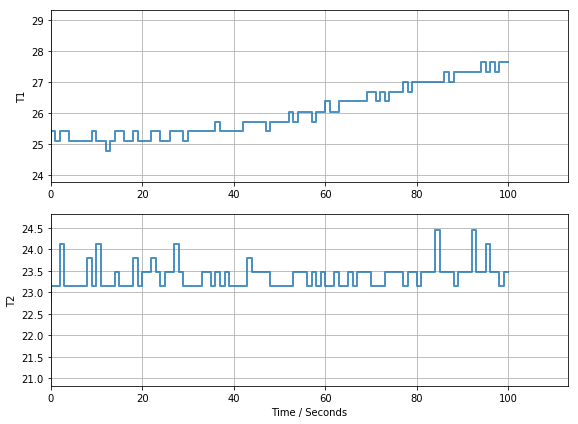

TCLab disconnected successfully.


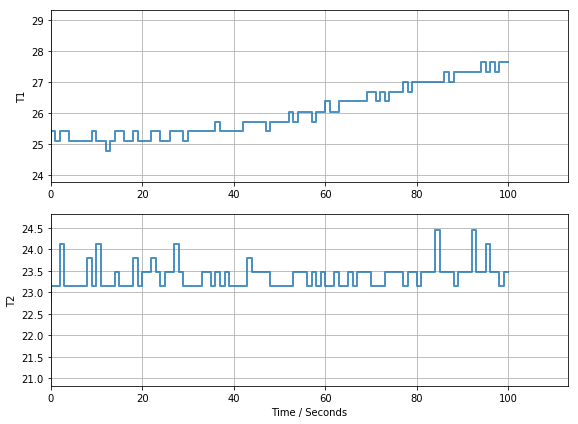

In [21]:
%matplotlib inline
from tclab import TCLab, clock, Historian, Plotter

with TCLab() as a:
    a.P1 = 250
    a.P2 = 50
    h = Historian([('T1', lambda: a.T1),('T2', lambda: a.T2)])
    p = Plotter(h)
    for t in clock(100):
        a.Q1(100 if t < 100 else 0)
        a.Q2(100 if t < 100 else 0)
        p.update(t)
